# <center> Проект 4: классификация

In [276]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import optuna
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [277]:
# Прочитаем данные
df_initial = pd.read_csv('data/bank_fin.csv', sep = ';')
display(df_initial.head())

# Сделаем копию
df = df_initial.copy()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


#### Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

#### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

#### Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке.

In [278]:
# Исследование данных и поиск пропущенных значений
display(df.info())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

##### Повнимательнее изучим некоторые столбцы, на пример неявных пропусков

In [279]:
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [280]:
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

##### Удаление лишних знаков для balance, так как валюта у нас одна

In [281]:
# Удаление всего, кроме цифр и десятичной точки
df['balance'] = df['balance'].str.replace(' \$', '', regex=True)  # Удаление знака доллара
df['balance'] = df['balance'].str.replace(' ', '', regex=True)    # Удаление пробелов
df['balance'] = df['balance'].str.replace(',', '.', regex=True)   # Замена запятой на точку)

# Преобразование в числовой тип
df['balance'] = pd.to_numeric(df['balance'], errors='coerce')

print('Пропусков после преобразования:', df['balance'].isna().sum())

#Проверка качества преобразования
print('Среднее:', round(df['balance'].mean(), 3))

Пропусков после преобразования: 25
Среднее: 1529.129


##### Обработка пропусков в непрерывных признаках

In [282]:
# Обработка пропусков в balance (меняем их на медианное значение)
df['balance'] = df['balance'].fillna(df['balance'].median())

print('Среднее:', round(df['balance'].mean(), 3))

Среднее: 1526.936


##### Обработка пропусков в категориальных признаках

In [283]:
# Обработка пропусков в job и education (меняем их на модальное значение)
df['job'] = df['job'].replace({'unknown': df['job'].mode()[0]})
df['education'] = df['education'].replace({'unknown': df['education'].mode()[0]})

print(round(df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean(), 3))

1598.883


##### Очистка от выбросов

In [284]:
df['balance'].sort_values(ascending=False)

3380     81204.0
3043     81204.0
8208     66653.0
10143    56831.0
2468     52587.0
          ...   
6010     -2049.0
6388     -2282.0
10642    -2712.0
1525     -3058.0
6797     -6847.0
Name: balance, Length: 11162, dtype: float64

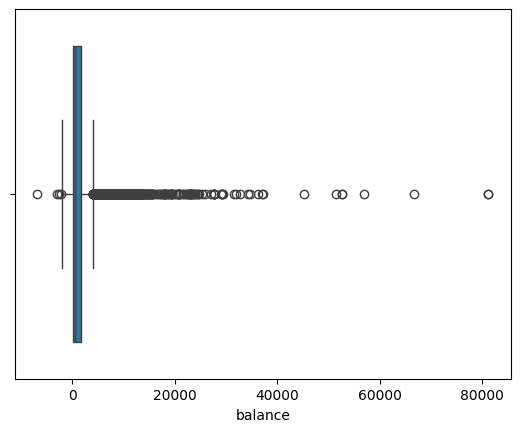

Нижняя граница: -2241.0
Верхняя граница: 6427.0
Всего значений признака: 11162
Число выбросов по методу Тьюки: 518
Число значений после применения метода Тьюки: 10644


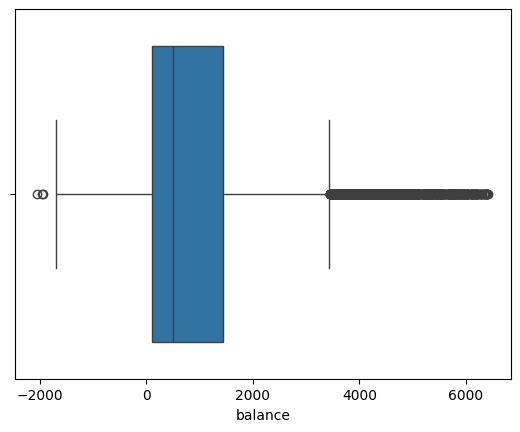

In [285]:
# Смотрим признак balance на предмет выбросов

# До чистки
plt.figure()
sns.boxplot(data=df, x='balance')
plt.show()

# Чистка
def outliers_iqr_mod(data, feature, log_scale=False, left=1.5, right=1.5):
    
    """Функция для очистки дата-фрейма от выбросов по методу межквартильного размаха (метода Тьюки).

    Args:
        data (DataFrame): дата-фрейм с данными.
        feature (pd.Series): признак (столбец) из дата-фрейма. 
        log_scale (bool, optional): Логарифмирование в процессе работы функции. Defaults to False.
        left (float, optional): левый интервал, за пределами которого значения считаются выбросами. Defaults to 1.5.
        right (float, optional): правый интервал, за пределами которого значения считаются выбросами. Defaults to 1.5.

    Returns:
        outliners (DataFrame): дата-фрейм со строками, которые функция посчитала выбросами.
        cleaned (DataFtame): очищенный от выбросов дата-фрейм. 
    """    
    
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    print('Нижняя граница:', lower_bound)
    upper_bound = quartile_3 + (iqr * right)
    print('Верхняя граница:', upper_bound)
    outliners = data[(x < lower_bound)|(x > upper_bound)]
    cleaned = data[(x >= lower_bound)&(x <= upper_bound)]
    return outliners, cleaned


outliners, cleaned = outliers_iqr_mod(df, 'balance', left=1.5, right=3)
print('Всего значений признака:', df['balance'].shape[0])
df = cleaned
print(f'Число выбросов по методу Тьюки: {outliners.shape[0]}')
print(f'Число значений после применения метода Тьюки: {cleaned.shape[0]}')

#После чистки
plt.figure()
sns.boxplot(data=df, x='balance')
plt.show()

## Часть 2:  Разведывательный анализ

##### Распределение целевого признака

In [286]:
# Рассмотрим распределение целевого признака
fig1 = px.pie(
    data_frame=df, 
    names='deposit'
)
fig1.update_layout(title={'text': "Соотношение людей, открывших депозит и тех, кто этого не делал", 'x': 0.5})
fig1.update_layout(height=600)
fig1.show()

#Отношение в числах
print('Клиентов, открывших депозит:', df['deposit'].value_counts()[1])

Клиентов, открывших депозит: 4995


##### Распределения количественных признаков

In [287]:
# Распределение признака возраста
fig2 = px.histogram(
    data_frame=df, 
    x='age',
    labels={'count': "Количество",
            'age': 'Возраст'}
)
fig2.update_layout(title={'text': "Распределение признака возраста", 'x': 0.5})
fig2.show()

# Задание 3.2
print('Максимальный возраст клиента:', df['age'].max())


# Распределение признака длительности разговора
fig3 = px.box(
    data_frame=df, 
    x='duration',
    labels={'duration': 'Длительность разговора'}
)
fig3.update_layout(title={'text': "Распределение признака длительности разговора", 'x': 0.5})
fig3.show()

# Задание 3.3
print('Минимальная продолжительность разговора с клиентом:', df['duration'].min())

Максимальный возраст клиента: 95


Минимальная продолжительность разговора с клиентом: 2


По возрасту ничего необычного. Да, есть люди, которым за 90, но их единицы. Такое допускается. Нет клиентов, которым за 100 лет, а также кому меньше 18. Распределение близко к нормальному, если отбросить всех, кому больше 65 лет. Основная аудитория банка - люди от 25 до 60 лет, то есть явно работающие. Сильный рост начинается в районе 23-24 лет, когда большинство заканчивают институты, и основной спад - в районе 60 лет, скорее всего связан с выходом человека на пенсию. Для большей информативности не помешало бы узнать год исследования.

По разговору - почти четыре тысячи секунд - это более часа разговора. Я бы ограничился получасом, остальное считал бы как выброс. Но пока с этим повременю. В остальном - ничего необычного. Распределение ненормальное.

UPD: Признак оказался довольно важным для целевого. Решил оставить его неизменным.

##### Распеределения категориальных признаков

In [288]:
# Распределение звонков по месяцам
fig4 = px.pie(
    data_frame=df, 
    names='month'
)
fig4.update_layout(title={'text': "Объём маркетинговой компании по месяцам", 'x': 0.5})
fig4.update_layout(height=600)
fig4.show()

print('Месяцев, в которых проводилась маркетинговая компания:', df['month'].value_counts().count())


# Распределение профессий участвующих
fig5 = px.pie(
    data_frame=df, 
    names='job'
)
fig5.update_layout(title={'text': "Распределение профессий пользователей, участвовавших в маркетинговой компании", 'x': 0.5})
fig5.update_layout(height=600)
fig5.show()

print('Сфер представлено среди клиентов банка:', df['job'].value_counts().count())

Месяцев, в которых проводилась маркетинговая компания: 12


Сфер представлено среди клиентов банка: 11


Получается, маркенговая компания велась круглый год. Сколько лет она длилась - неизвестно, а жаль. Но, судя по тому, что в начале дата-фрейма и лидирующий месяц - май, именно с него она началась. Тогда видим, что лидирующие месяцы - это начало компании, но ближе к концу года интерес пропал. И потом снова появился ближе к лету. Возможно также, что имеется связь с сезонностью и периодом отпусков и праздников.

По распределению сфер - сильно лидирует рабочий класс, рабочие люди. Хотя информации, как по мне, недостаточно. Хотелось бы больше классов. Студентов, самозанятых, домохозяек и других людей, которые немного зарабатывают, если вообще зарабатывают, немного, в сумме около 15% на всех. И 6.5% потенциальных пенсионеров.

##### Сравним текущую и предыдущую компанию

In [289]:
# Группируем значения для визуализации
filtered_data_poutcome = df.groupby(
    by=['deposit', 'poutcome'],
    as_index=False
)['deposit'].value_counts()

# Визуализация
fig6 = px.bar(
    data_frame=filtered_data_poutcome,
    x='count',
    y='poutcome',
    color = 'deposit',
    barmode='group',
    labels={
        'poutcome': 'Статус предыдущей компании',
        'deposit': 'Успех на текущей компании',
        'count': 'Количество',
        }
)
fig6.update_layout(title={'text': "Зависимость результатов текущей маркетинговой кампании и предыдущей", 'x': 0.5})
fig6.show()

Наглядно видим, что люди, которые пользовались услугами банка в период предыдущей компании в большинстве своём продолжают охотно открывать депозиты.

При этом те, кто, по всей видимости, не застал предыдущую компанию, отказываются от услуги. Судя по количеству тех, кто отказался в прошлый раз, но в этот раз воспользовался услугой, в следующий раз распределение этих новых клиентов будет более ровным, т.е. депозитов откроется больше у этой категории.

##### Посмотрим, в каком месяце чаще всего отказывались от предложения открыть депозит

In [290]:
# Группируем значения для визуализации
filtered_data_deposit_month = df.groupby(
    by=['deposit', 'month'],
    as_index=False
)['deposit'].value_counts()

# Визуализация
fig7 = px.bar(
    data_frame=filtered_data_deposit_month,
    x='count',
    y='month',
    color = 'deposit',
    barmode='group',
    title='Зависимость результатов маркетинговой кампании от месяца',
    labels={
        'month': 'Месяц',
        'deposit': 'Успех на текущей компании',
        'count': 'Количество',
        }
)
fig7.update_layout(height=800)
fig7.update_layout(title={'text': 'Успех на текущей компании', 'x': 0.5})
fig7.show()

Самые успешные периоды для маркетинговой компании - ранняя весна и ранняя осень. Самый провальный - май месяц. Странно видеть такой резкий спад после апреля и марта. Возможно это связано с навязчивой рекламой от банка, так как было предположение, что она началась именно в мае. Также наблюдаются подъёмы в предпраздничные или праздничные месяцы, если праздники не начинаются с начала месяца (декабрь, февраль, март). Это может быть связано с сезоном подарков. В сезоны отпусков люди к открытию депозитов относятся прохладно. 

##### Посмотрим, в каких возрастных группах люди более склонны открывать депозит, чем отказываться от предложения.

In [291]:
# age_untill_30 = df[df['age'] < 30]
# age_30_40 = df[(df['age'] >= 30) & (df['age'] < 40)]
# age_40_50 = df[(df['age'] >= 40) & (df['age'] < 50)]
# age_50_60 = df[(df['age'] >= 50) & (df['age'] < 60)]
# age_60_and_above = df[df['age'] >= 60]
# Далее через If, но ответ с платформой не сходится

labels = ['<30', '30-40', '40-50', '50-60', '60+']
df['age_group_cut'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 999], labels=labels)

# Для визуализации
filtered_data_age_groups = df.groupby(
    by=['age_group_cut'],
    as_index=False
)['deposit'].value_counts()

# Визуализация
fig8 = px.bar(
    data_frame=filtered_data_age_groups, 
    x='age_group_cut', 
    y='count', 
    color='deposit', 
    barmode='group',
    title='Успех маркетиноговой компании по возрастным группам',
    labels={
        'deposit': 'Успех компании',
        'age_group_cut': 'Возрастные группы',
        'count': 'Количество пользователей'
    }
)
fig8.update_layout(height=700)
fig8.update_layout(title={'text': 'Успех маркетиноговой компании по возрастным группам', 'x': 0.5})
fig8.show()

Наиболее склонные группы к открытию депозита после маркетинговой компании - самая младшая и старшая группы. Остальные, хоть и имеют численное преимущество, чаще отклоняют предложение об открытии депозита, чем принимают.

##### Посмотрим, влияет ли семейный статус на успех маркетинговой компании

In [292]:
# Для визуализации
filtered_data_deposit_marital = df.groupby(
    by=['marital'],
    as_index=False
)['deposit'].value_counts()

# Визуализация
fig9 = px.bar(
    data_frame=filtered_data_deposit_marital, 
    x='marital', 
    y='count', 
    color='deposit', 
    barmode='group',
    title='Успех маркетиноговой компании в зависимости от семейного положения пользователя',
    labels={
        'deposit': 'Успех компании',
        'marital': 'Семейное положение',
        'count': 'Количество пользователей'
    }
)
fig9.update_layout(height=700)
fig9.update_layout(title={'text': 'Успех маркетиноговой компании в зависимости от семейного положения пользователя', 'x': 0.5})
fig9.show()

Одиночки больше склонны к открытию счета. Видимо, это связано с возможными рисками для семьи.

##### Посмотрим, влияет ли образование на успех маркетинговой компании

In [293]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

# Для визуализации
filtered_data_deposit_education = df.groupby(
    by=['education'],
    as_index=False
)['deposit'].value_counts()

# Визуализация
fig9 = px.bar(
    data_frame=filtered_data_deposit_education, 
    x='education', 
    y='count', 
    color='deposit', 
    barmode='group',
    title='Успех маркетиноговой компании в зависимости от образования пользователя',
    labels={
        'deposit': 'Успех компании',
        'education': 'Образование',
        'count': 'Количество пользователей'
    }
)
fig9.update_layout(height=700)
fig9.update_layout(title={'text': 'Успех маркетиноговой компании в зависимости от образования пользователя', 'x': 0.5})
fig9.show()

Для справки:
* primary - начальное образование, не более 8 классов при переводе на русскую систему образования;
* secondary - среднее и среднеспециальное образование;
* terriary - высшее+ образование.

Видим, что люди с высшим образованием охотнее всех соглашаются на предложение об открытии депозита в банке. При этом превалируют люди со средним образованием.

In [294]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

# Для визуализации
filtered_data_deposit_job = df.groupby(
    by=['job'],
    as_index=False
)['deposit'].value_counts()

# Визуализация
fig9 = px.bar(
    data_frame=filtered_data_deposit_job, 
    x='job',
    y='count',
    color='deposit',
    barmode='group',
    title='Успех маркетиноговой компании в зависимости от вида профессиональной деятельности',
    labels={
        'deposit': 'Успех компании',
        'job': 'Вид профессиональной деятельности',
        'count': 'Количество пользователей'
    }
)
fig9.update_layout(height=700)
fig9.update_layout(title={'text': 'Успех маркетиноговой компании в зависимости от вида профессиональной деятельности', 'x': 0.5})
fig9.show()

Интересно. Маркетинговая компания лучше всех работает на неработающие слои населения, особенно сильно это видно на студентах. При этом на класс "Синих воротничков" компания работает хуже всех. Возможно, стоит провести оптимизацию в будущих компаниях.

##### Посмотрим, люди с каким образованием и семейным статусом наиболее многочисленны

In [295]:
# Строим сводные таблицы
deposit_yes = df[df['deposit'] == 'yes']
deposit_no = df[df['deposit'] == 'no']

deposit_yes_crosstab = pd.crosstab(
    deposit_yes['education'],
    deposit_yes['marital']
)

deposit_no_crosstab = pd.crosstab(
    deposit_no['education'],
    deposit_no['marital']
)
display(deposit_no_crosstab)
display(deposit_yes_crosstab)

# Визуализация в виде тепловой карты
fig10 = make_subplots(rows=1, cols=2, subplot_titles=[
    'Пересечение категорий образования и семейного положения для открывших депозит',
    'Пересечение категорий образования и семейного положения для не открывших депозит'
    ])

fig10.add_trace(go.Heatmap(
    x=deposit_yes_crosstab.columns.to_list(),
    y=deposit_yes_crosstab.index.to_list(),
    z=deposit_yes_crosstab,
    text=deposit_yes_crosstab.values,
    texttemplate='%{text}'
    ), row=1, col=1)
fig10.add_trace(go.Heatmap(
    x=deposit_yes_crosstab.columns.to_list(),
    y=deposit_yes_crosstab.index.to_list(),
    z=deposit_no_crosstab,
    text=deposit_no_crosstab.values,
    texttemplate='%{text}'
    ), row=1, col=2)
fig10.update_layout(height=700)
fig10.update_xaxes(title_text='Семейное положение')
fig10.update_yaxes(title_text='Образование')
fig10.update_layout(title={'text': "Пересечение категорий образования и семейного положения", 'x': 0.5})

fig10.show()

marital,divorced,married,single
education,,,
primary,97,678,102
secondary,379,1901,895
tertiary,174,870,553


marital,divorced,married,single
education,,,
primary,100,368,83
secondary,305,1370,919
tertiary,189,852,809


В обеих случаях самая распространённая вариация категорий - женатый пользователь со средним образованием.

## Часть 3: преобразование данных

##### Кодирование возрастных групп и образования

In [296]:
# Кодировать буду с помощью LabelEncoder
le = LabelEncoder()

df['education'] = le.fit_transform(df['education'])
df['age_group_cut'] = le.fit_transform(df['age_group_cut'])

##### Кодирование бинарных признаков

In [297]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)

print('Ответ для задания 4.2:', round(df['deposit'].std(), 3))
print('Ответ для задания 4.3:', round((df['loan'].mean() + df['housing'].mean() + df['default'].mean()), 3))
df.info()

Ответ для задания 4.2: 0.499
Ответ для задания 4.3: 0.629
<class 'pandas.core.frame.DataFrame'>
Index: 10644 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            10644 non-null  int64  
 1   job            10644 non-null  object 
 2   marital        10644 non-null  object 
 3   education      10644 non-null  int32  
 4   default        10644 non-null  int64  
 5   balance        10644 non-null  float64
 6   housing        10644 non-null  int64  
 7   loan           10644 non-null  int64  
 8   contact        10644 non-null  object 
 9   day            10644 non-null  int64  
 10  month          10644 non-null  object 
 11  duration       10644 non-null  int64  
 12  campaign       10644 non-null  int64  
 13  pdays          10644 non-null  int64  
 14  previous       10644 non-null  int64  
 15  poutcome       10644 non-null  object 
 16  deposit        10644 non-null  int64  
 1

##### Кодирование остальных признаков однократным кодированием

In [298]:
# Список колонок для кодирования
columns_to_change = ['job', 'marital', 'contact', 'month', 'poutcome']

# Инициализация кодировщика
ohe = OneHotEncoder()
coded_columns = ohe.fit_transform(df[columns_to_change]).toarray()
column_names = ohe.get_feature_names_out(columns_to_change)

df_onehot = pd.DataFrame(coded_columns, index=df.index, columns=column_names)
df = pd.concat([df, df_onehot], axis=1)


print('Ответ для платформы:', df.columns.value_counts().sum())

# Удаление изначальных признаков
df = df.drop(columns_to_change, axis=1)

Ответ для платформы: 51


##### Построение тепловой карты корреляции признаков

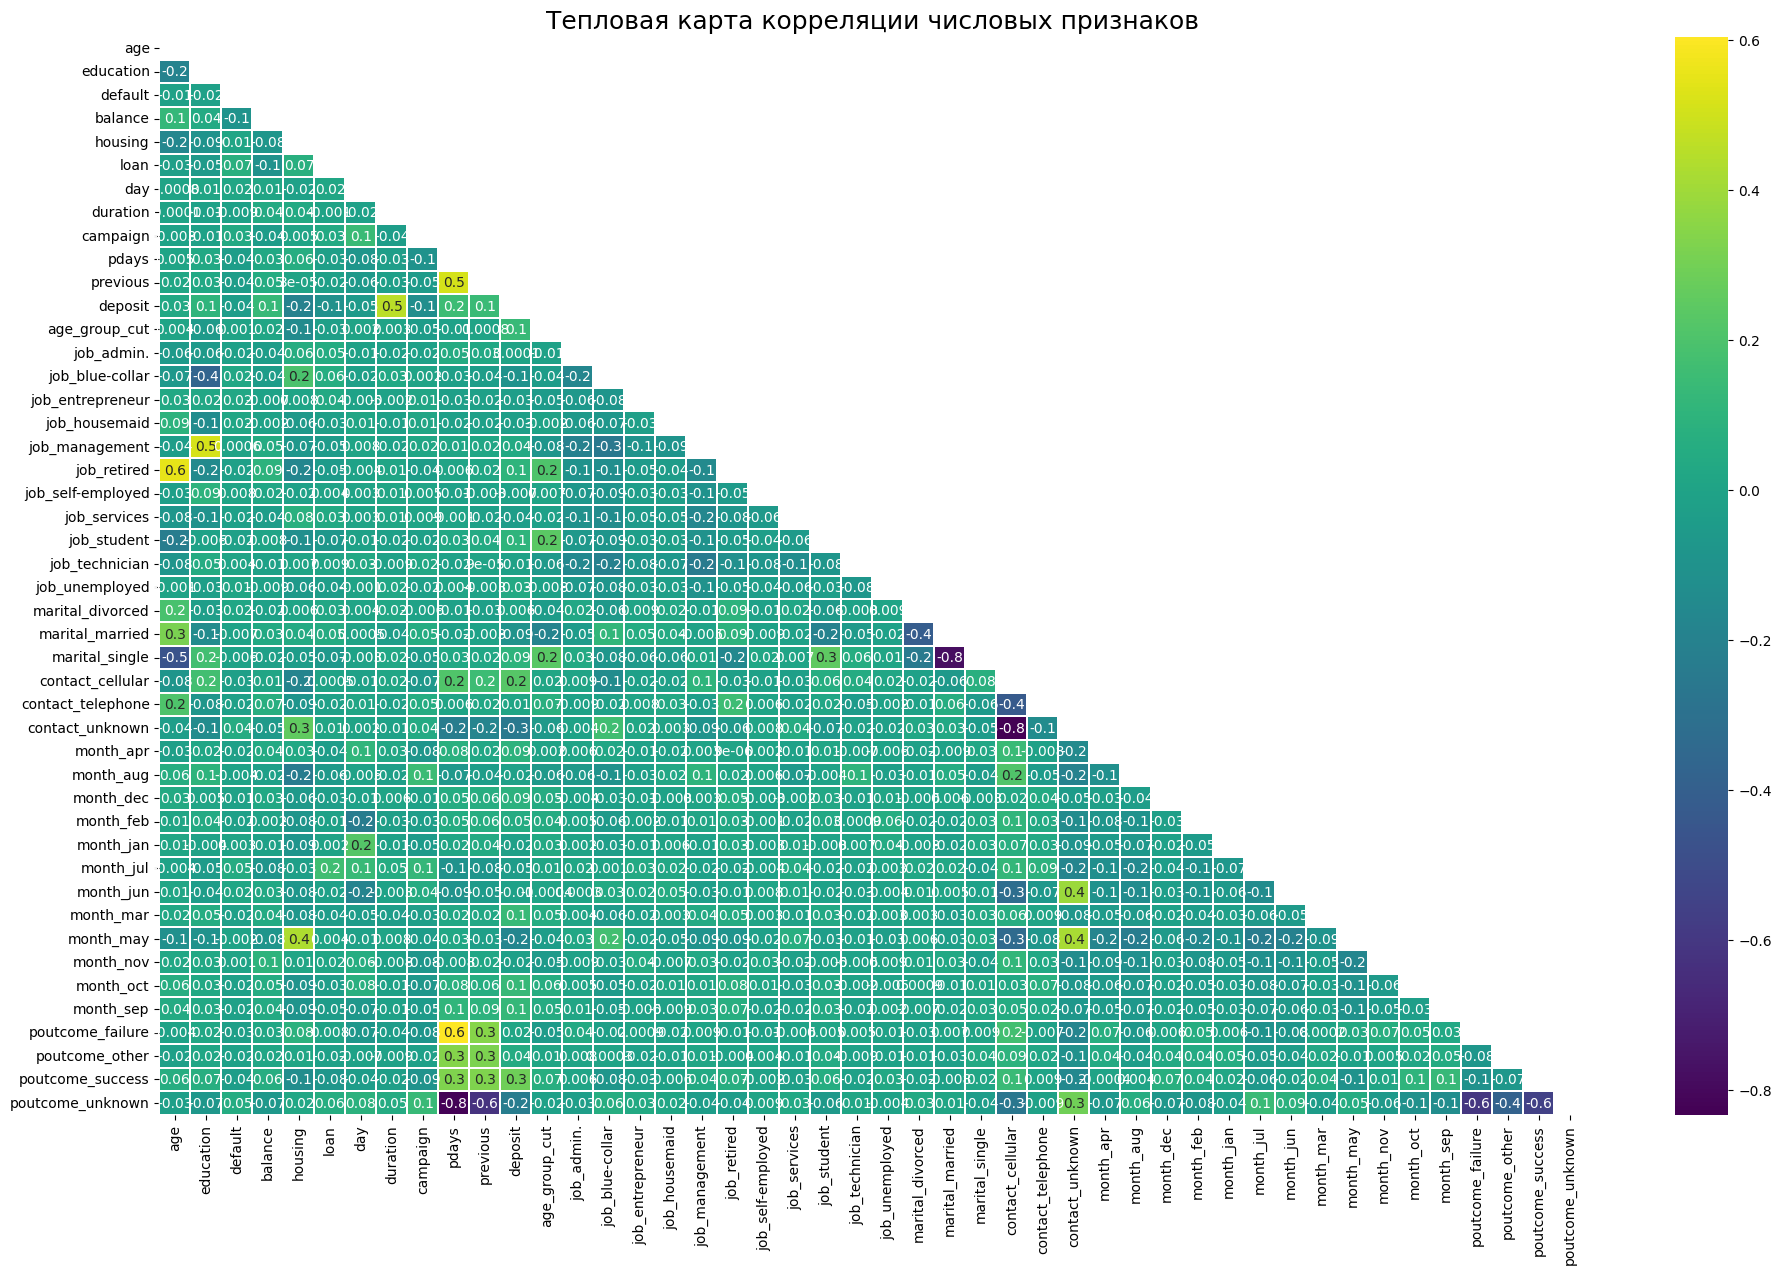

In [299]:
# Выделяем числовые и логические столбцы
numeric_columns = df.select_dtypes(exclude=['object', 'bool']).columns.to_list()

def show_corr_heatmap(columns_list, title, method='pearson'):
    #Функция для настройки визуализации корреляций
    fig_, ax_ = plt.subplots(figsize=(23, 14))
    corr = df[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr,
                annot=True,
                linewidths=0.1,
                ax=ax_,
                mask=mask,
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()
    
# Строим матрицу корреляции с помощью функции
show_corr_heatmap(numeric_columns, title='Тепловая карта корреляции числовых признаков')

##### Разделение данных на выборки

In [300]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [301]:
print('Задание 4.7:', X_test.shape[0])
print('Задание 4.8:', round(y_test.mean(), 2))

Задание 4.7: 3513
Задание 4.8: 0.47


##### Отбор признаков

In [302]:
# с помощью SelectKBest отбераем 15 наиболее подходящих признаков

selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

X_train = X_train[list(selector.get_feature_names_out())]
X_test = X_test[list(selector.get_feature_names_out())]

selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group_cut', 'contact_cellular', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'month_sep',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

##### Нормализация данных

In [303]:
# Инициализация minmaxscaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Ответ для платформы:', round(X_test_scaled[:, 0].mean(), 2))

Ответ для платформы: 0.36


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

##### Обучение стандартных моделей

In [304]:
# Обучение модели линейной регрессии
lr = linear_model.LogisticRegression(
    max_iter=1000, 
    solver='sag', 
    random_state=42
)

lr.fit(X_train_scaled, y_train)

y_train_pred_lr = lr.predict(X_train_scaled)
y_test_pred_lr = lr.predict(X_test_scaled)
print('Accuracy train:', round(metrics.accuracy_score(y_train, y_train_pred_lr), 2))
print('Accuracy test:', round(metrics.accuracy_score(y_test, y_test_pred_lr), 2))
print(metrics.classification_report(y_test, y_test_pred_lr))

Accuracy train: 0.82
Accuracy test: 0.82
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1864
           1       0.84      0.75      0.80      1649

    accuracy                           0.82      3513
   macro avg       0.82      0.81      0.82      3513
weighted avg       0.82      0.82      0.82      3513



In [305]:
# Обучение дерева решений

dt = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)

dt.fit(X_train_scaled, y_train)

y_train_pred_dt = dt.predict(X_train_scaled)
y_test_pred_dt = dt.predict(X_test_scaled)
print('Accuracy train:', round(metrics.accuracy_score(y_train, y_train_pred_dt), 2))
print('Accuracy test:', round(metrics.accuracy_score(y_test, y_test_pred_dt), 2))
print(metrics.classification_report(y_test, y_test_pred_dt))

# Наблюдается переобучение. Исправим это:
print('-'*50)

dt = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42,
    max_depth=6
)

dt.fit(X_train_scaled, y_train)

y_train_pred_dt = dt.predict(X_train_scaled)
y_test_pred_dt = dt.predict(X_test_scaled)
print('Accuracy train:', round(metrics.accuracy_score(y_train, y_train_pred_dt), 2))
print('Accuracy test:', round(metrics.accuracy_score(y_test, y_test_pred_dt), 2))
print(metrics.classification_report(y_test, y_test_pred_dt))

Accuracy train: 1.0
Accuracy test: 0.77
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1864
           1       0.76      0.73      0.75      1649

    accuracy                           0.77      3513
   macro avg       0.77      0.77      0.77      3513
weighted avg       0.77      0.77      0.77      3513

--------------------------------------------------
Accuracy train: 0.81
Accuracy test: 0.8
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1864
           1       0.77      0.83      0.79      1649

    accuracy                           0.80      3513
   macro avg       0.80      0.80      0.80      3513
weighted avg       0.80      0.80      0.80      3513



##### Подбор оптимальных параметров с помощью GridSearch

In [306]:
# Параметры для подбора
parameters = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

# Инициализация алгоритма поиска
grid_search = GridSearchCV(
    param_grid=parameters,
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy', 
        random_state=42
        ),
    cv=5, 
    n_jobs=-1
)
%time grid_search.fit(X_train_scaled, y_train)

y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе:', round(metrics.f1_score(y_test, y_test_pred), 2))

CPU times: total: 78.1 ms
Wall time: 1.58 s
f1_score на тестовом наборе: 0.8


Как будто бы базовой модели недостаточно. Нужно попробовать ансамблирование.

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

##### Обучение случайного леса

In [307]:
# Инициализация алгоритма
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
y_test_pred_rf = rf.predict(X_test_scaled)
print('Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred_rf), 2))
print('Recall:', round(metrics.recall_score(y_test, y_test_pred_rf), 2))
print('F1_score:', round(metrics.f1_score(y_test, y_test_pred_rf), 2))

Accuracy: 0.84
Recall: 0.84
F1_score: 0.83


##### Обучение модели градиентного бустинга для сравнения со случайным лесом

In [308]:
# Инициализаця модели
gbc = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

gbc.fit(X_train_scaled, y_train)
y_test_pred_gbc = gbc.predict(X_test_scaled)
print('Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred_gbc), 2))
print('Recall:', round(metrics.recall_score(y_test, y_test_pred_gbc), 2))
print('F1_score:', round(metrics.f1_score(y_test, y_test_pred_gbc), 2))

Accuracy: 0.83
Recall: 0.84
F1_score: 0.82


Результат пока 1 в 1 со случайным лесом. Зато время обучения больше в несколько раз.

##### Попробуем стэкинг

In [309]:
# Для обучения используем все вышеиспользованные модели, за исключением случайного леса
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stclf = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        random_state=42
    )
)

stclf.fit(X_train_scaled, y_train)
y_test_pred_stclf = stclf.predict(X_test_scaled)
print('Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred_stclf), 2))
print('Precision:', round(metrics.precision_score(y_test, y_test_pred_stclf), 2))
print('F1_score:', round(metrics.f1_score(y_test, y_test_pred_stclf), 2))

Accuracy: 0.83
Precision: 0.82
F1_score: 0.82


Качество модели один в один как до этого. В стэкинге смысла нет.

### Задание 5

In [310]:
# оцените, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга

Тут даже не обязательно что-то строить. Очевидно, что самые важные признаки те, которые наиболее скорелированы с целевым признаком. Потому смотрим тепловую карту корреляций

##### Попробуем создать и оптимизировать гиперпараметры случайного леса

In [ ]:
# Для оптимизации используем Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(
     n_estimators=n_estimators,
     max_depth=max_depth,
     min_samples_leaf=min_samples_leaf,
     random_state=42
  )
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# Инициализируем подбор параметров, 30 итераций
study = optuna.create_study(study_name='Random_forest_classification', direction='maximize')
study.optimize(optuna_rf, n_trials=30)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# Обучаем чистовую модель с подобранным лучшим
# сочетанием гиперпараметров
rfc = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
rfc.fit(X_train_scaled, y_train)
y_test_pred_opt = rfc.predict(X_test_scaled)
print('Accuracy:', round(metrics.accuracy_score(y_test, y_test_pred_opt), 2))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))
print('F1 score (test):', round(metrics.f1_score(y_test, y_test_pred_opt), 2))

[I 2025-02-14 19:12:52,522] A new study created in memory with name: Random_forest_classification
[I 2025-02-14 19:12:53,229] Trial 0 finished with value: 0.8655327809274603 and parameters: {'n_estimators': 194, 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8655327809274603.
[I 2025-02-14 19:12:53,824] Trial 1 finished with value: 0.8456925552142752 and parameters: {'n_estimators': 195, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8655327809274603.
[I 2025-02-14 19:12:54,277] Trial 2 finished with value: 0.8501762632197415 and parameters: {'n_estimators': 147, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8655327809274603.
[I 2025-02-14 19:12:54,656] Trial 3 finished with value: 0.8610544713078939 and parameters: {'n_estimators': 113, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8655327809274603.
[I 2025-02-14 19:12:55,012] Trial 4 finished with value: 0.8739028671737858 and parameter

Наилучшие значения гиперпараметров {'n_estimators': 104, 'max_depth': 21, 'min_samples_leaf': 2}
Accuracy: 0.83
f1_score на обучающем наборе: 0.92
F1 score (test): 0.82


In [ ]:
# График итерационного подбора парметров
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [ ]:
# График наиболее важных гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="f1_score")

## Вывод

В результате получили модель, способную предсказывать открытие депозита в банке пользователем. Обработали и исследовали данные, подготовили их к обучению. Попробовали разные модели и их связки, по итогу самое эффективное - случайный лес после подбора параметров с помощью Optuna. С её помощью модель выходит более стабильной и при этом показывает результат. Также такой подбор удобно визуализировать.